In [2]:
import multiprocessing
import numpy as np
from math import *
import matplotlib.pyplot as plt
from functools import partial
from scipy.interpolate import griddata
from PIL import Image
import json

C:\Users\dpani\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(115, 116)

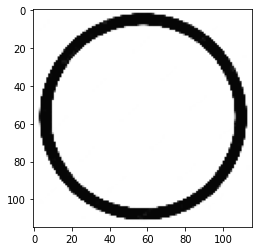

In [47]:
image = Image.open('image2.png')
pixel_size = 5 #reduzco complejidad
ancho, alto = image.size
nuevo_ancho = ancho // pixel_size
nuevo_alto = alto // pixel_size
imagen_pixelada = image.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
image = imagen_pixelada.convert('L')
image = np.array(image)
#image = np.random.rand(2,2)
plt.imshow(image,cmap='gray')
image.shape

In [48]:
class GCell:
    def __init__(self):
        self.recprof = lambda posiciones : np.exp(-((posiciones[:,:,0])**2 + (posiciones[:,:,1])**2)) * np.exp(2j*(posiciones[:,:,1]))
        
def Accion(posiciones,x,y,phi):
    return np.add(np.matmul(posiciones,np.array([[cos(phi),-sin(phi)],[sin(phi),cos(phi)]])), np.array([x,y]))

def AccionInv(posiciones,x,y,phi):
    #devuelve el punto con la rotacion inversa y desplazado -
    return np.matmul((posiciones - np.array([x,y])), np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]))
    #return (posiciones - np.array([x,y])) @ np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]) #no mejora el rendimiento

def O(x,y,phi,imagen,gcell,posiciones):
    #debería cambiar la suma por algo mejor? que aproxime mejor la integral
    return np.sum(imagen * gcell.recprof(posiciones))

class V1:
    def __init__(self, height, width, imagen):
        #inicio un tablero con las células ganglionares bajo la acción del grupo E(2), rotaciones y traslaciones en el plano
        # estaria bien hacer que no dependiera de la imagen elegida (se adapte al tamaño)
        #imagen: 
        self.n = imagen.shape[0]
        #posiciones es una discretacizacion del plano por puntos con coordenadas (i,j) habrá que crear células ganglionales con distintas posiciones
        posiciones = np.array(list(product(np.arange(1,self.n+1),repeat=2))).reshape((self.n,self.n,2))
        self.reticulo = None
        pass

def searchPhiP(x,y,imagen,gcell):
    posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))
    #posicionesRotTrans = lambda phi : AccionInv(posiciones,x,y,phi) #rotamos y trasladamos
    
    espacioBusqueda = np.linspace(0,pi,15) #bajo los cortes, las fibras son S1 pero modulo pi
    #espacioBusqueda = np.linspace(0,2*pi,20) #bajo los cortes tomamos las fibras como S1; asi no sale
    
    return espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))]

def allPhiP(imagen,gcell):
    arr = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])
    prefdOr = {(x,y):searchPhiP(x,y,imagen,gcell) for x,y in arr}
    return prefdOr

def scatterDict(datos,image,plotProyection):
    x = np.array([coord[0] for coord in datos.keys()])
    y = np.array([coord[1] for coord in datos.keys()])
    z = np.array(list(datos.values()))
    
    mycmap = 'viridis'
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(2, 2, 1)
    scatter1 = ax1.scatter(y, -x, c=z, cmap=mycmap) #invierto, si no sale al reves
    ax1.set_aspect('equal')
    ax1.set_xlabel('Eje X')
    ax1.set_ylabel('Eje Y')
    ax1.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter1, ax=ax1, label='Orientación preferida [0,pi]',fraction=0.046, pad=0.04)
    
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    if plotProyection:
        z_ = np.zeros(np.array(list(datos.values())).shape) #sirve para visualizar la proyección de los puntos
        scatter2 = ax2.scatter(x, y, z_, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    else:
        scatter2 = ax2.scatter(x, y, z, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    ax2.set_xlabel('Eje X')
    ax2.set_ylabel('Eje Y')
    ax2.set_zlabel('PhiP')
    ax2.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter2, ax=ax2, label='Altura = PhiP',fraction=0.046, pad=0.04)
    plt.tight_layout()
    
#     ax3 = fig.add_subplot(2, 2, 3)
#     x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
#     z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')
#     ax3.imshow(z_grid.T, cmap=mycmap) #traspongo la matriz imagen para que este bien orientada
#     ax3.set_title('Interpolación de los puntos')
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.imshow(image, cmap = 'gray')
    
    plt.show()


In [ ]:
mycell = GCell()
%time mydict = allPhiP(image,mycell)

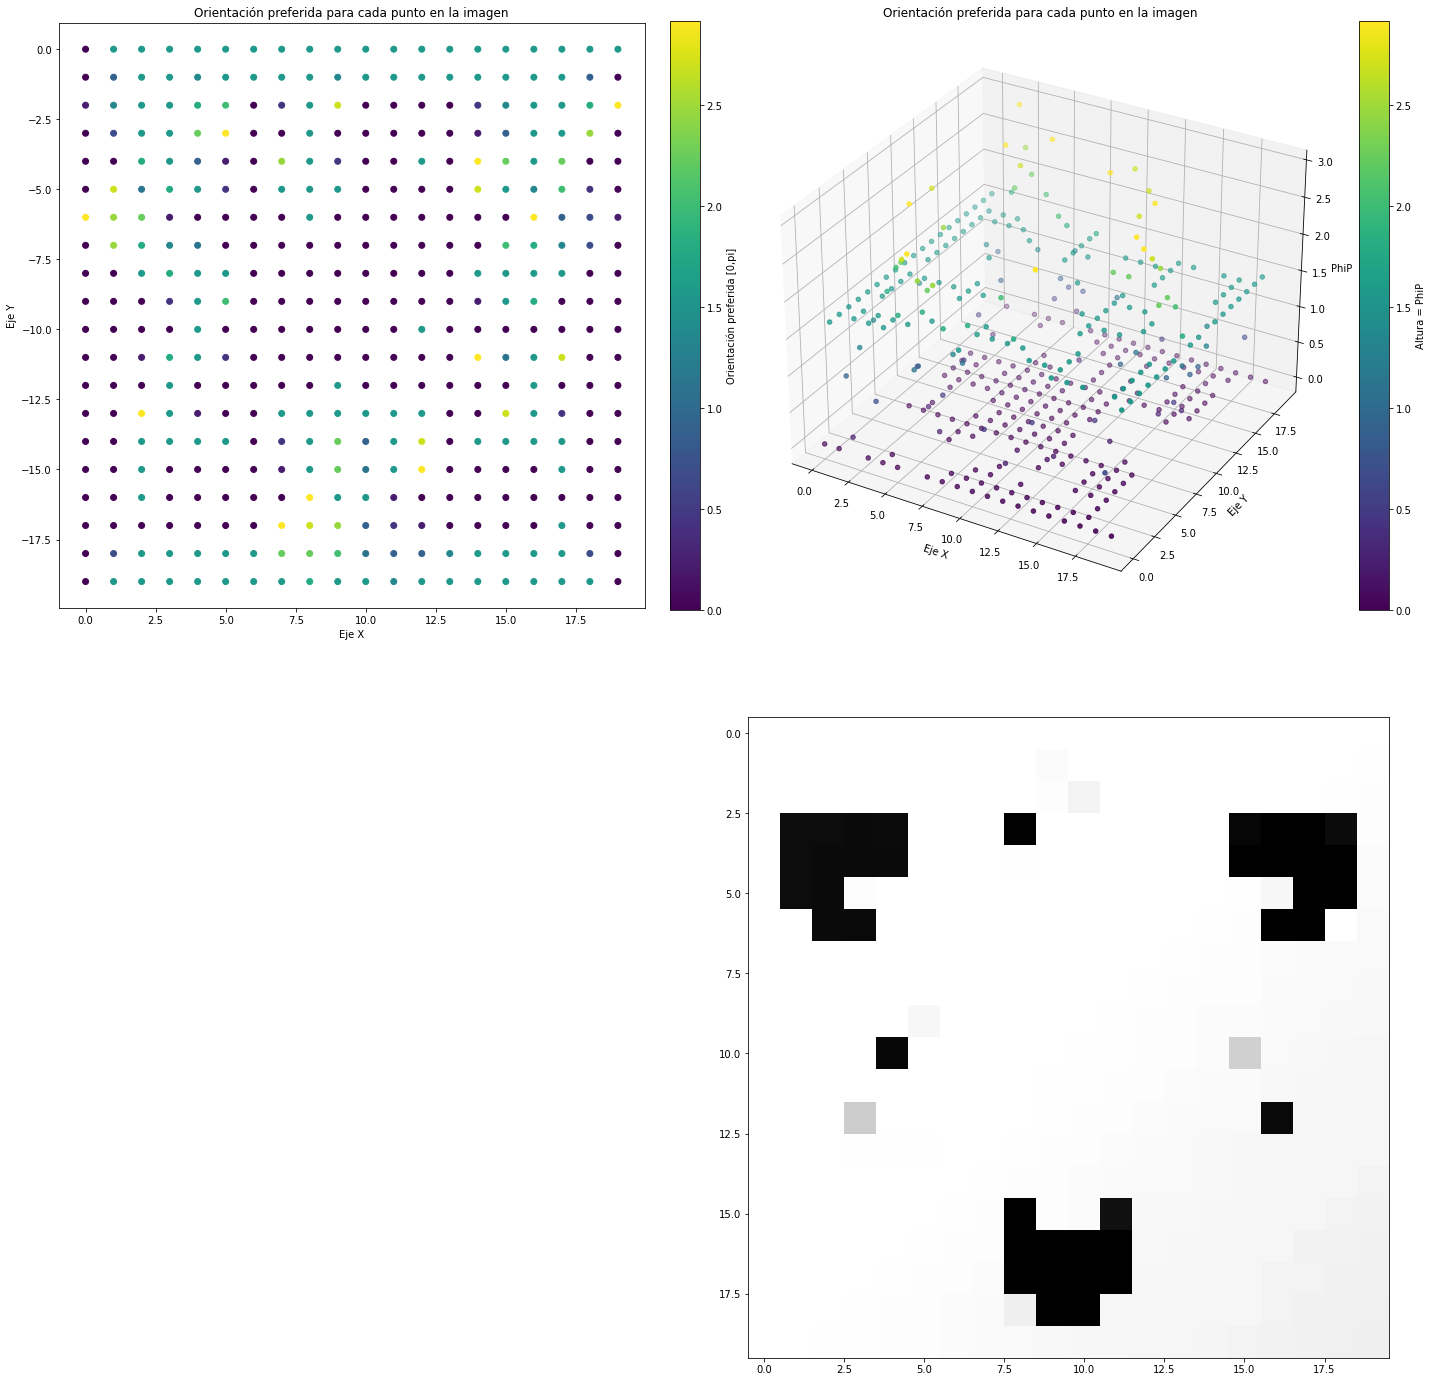

In [46]:
scatterDict(mydict,image,False)

In [6]:
with open('im2arrayv3.json', 'w') as file:
    json.dump({str(k): v for k, v in mydict.items()}, file, indent=4)

In [18]:
with open('safeCalcs/im2arrayv3.json') as file:
    aux = json.load(file)

In [19]:
mydict2 = {eval(k):v for k,v in aux.items()}

In [20]:
mydict = mydict2